In [2]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import morphology
from sklearn.metrics import pairwise_distances
from PIL import Image, ImageFilter, ImageDraw
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import mapalign
from mapalign import embed

def mask_image(filename):
    
    imgD = Image.open(filename)
    imgB = np.asarray(imgD).copy()
    imgB[:,:,:3] = np.where(imgB[:,:,:3] < 255, 0., 255.)
    imgB[:,:,3]  = np.where(imgB[:,:,3] > 1, 255., 0.)
    
    e = morphology.binary_fill_holes(imgB[:,:,3])
    e = morphology.binary_closing(e)
    e = morphology.binary_erosion(e)
    e = morphology.binary_erosion(e)
    e = morphology.binary_erosion(e)
    e = morphology.binary_erosion(e)
    e = morphology.binary_erosion(e)
    e = morphology.binary_erosion(e)
    im = imgB.copy()
    im[:,:,3] = e * im[:,:,3]
    im[:,:,0] = 255. - im[:,:,3]
    im[:,:,1] = 255. - im[:,:,3]
    im[:,:,2] = 255. - im[:,:,3]
    
    return np.asarray(im).astype('float')

col = {}
col['CTBgr']=1
col['CTBr']=0 
col['DY']=[1,2] 
col['FB']=2
col['FE']=1
col['FR']=0


def keep_Temp(dfX):
    dfX = dfX[(dfX.target.str.contains("Au")) | (dfX.target.str.contains("TPO")) | (dfX.target.str.contains("TE3")) | (dfX.target.str.contains("PGa"))]
    return dfX

def ind_keepTemp(dfX):
    return dfX[dfX.target.str.contains("Au") | dfX.target.str.contains("TPO") | dfX.target.str.contains("TE3") | dfX.target.str.contains("PGa")].index

def load_data(keepTemp = False):
    
    df_orig = pd.read_csv('../data/marmoset_brain_architecture_all_injections.txt')
    df_orig = df_orig.drop_duplicates(subset=['case_id', 'tracer_id'])

    if keepTemp:
        df_orig = keep_Temp(df_orig)

    with open('../data/injection_locations_on_flatmap.txt', 'r') as myfile:
        data=myfile.read().split("}, {")
    d = []
    for i in data:
        d.append(i.replace("{","").replace("}",""))
    x = json.loads("{" + d[0]+ "}")
    df = pd.DataFrame(columns=x.keys())
    for i in range(len(d)):
        x = json.loads("{" + d[i] + "}")
        df = df.append(x, ignore_index=True)
    
    unique_index1 = pd.Index(df['display_name'])
    unique_index2 = pd.Index(df['tracer'])
    unique_index3 = pd.Index(df['region'])

    df['stridx']=df.index

    id_flat = []
    for i,n in enumerate(df_orig['Unnamed: 0']):       
        try:            
            nx = np.where(unique_index1.str.contains(df_orig['case_id'].iloc[i]) & unique_index2.str.contains(df_orig['tracer_id'].iloc[i]))[0]
            if len(nx) == 1:
                id_flat.append(nx)
            else: 
                nx = np.where(unique_index1.str.contains(df_orig['case_id'].iloc[i][:4]) & unique_index2.str.contains(df_orig['tracer_id'].iloc[i]))[0]
                if len(nx) == 1:
                    id_flat.append(nx)
                else:
                    nx = np.where(unique_index1.str.contains(df_orig['case_id'].iloc[i][:5]) & unique_index2.str.contains(df_orig['tracer_id'].iloc[i]))[0]
                    if len(nx) == 1:
                        id_flat.append(nx)
                    else:                
                        nx = np.where(unique_index1.str.contains(df_orig['case_id'].iloc[i]) & unique_index2.str.contains(df_orig['tracer_id'].iloc[i]) &
                                      unique_index3.str.contains(df_orig['target'].iloc[i]))[0]
                        if len(nx) == 1:
                            id_flat.append(nx)
                        else:
                            print(df_orig['case_id'].iloc[i],  df_orig['tracer_id'].iloc[i], df_orig['target'].iloc[i])
        except:
            a = 1
            
    return df_orig, df, id_flat

# Load data
df_orig, df, id_flat = load_data()

# transform coordinates:
img = Image.open("../data/injections_bk/CJ182.DY.png")
flat = Image.open("../templates/flat_bw.png")  
y, x = flat.size                  
a, a, y, x = flat.getbbox()       

coords = np.matrix((np.array(df['flatmap_y']), np.array(df['flatmap_x']), np.ones(len(df['flatmap_x'])))).T
sx = 20.05
sy = sx
tx = x/2. + 93. 
ty = y/2. + 107.
transform = np.matrix([[sx, 0., 0.], [0., sy, 0.], [tx, ty, 1.]])
trans_coords = coords * transform
trans_coords = np.array(trans_coords[:,:2])

inj_circ_diam = 15

# Setup colors:
my_cmap = cm.get_cmap('jet')

pairs_setup = [[['78', 'FB'],
                ['173', 'DY']],
                [['111', 'FR'],
                ['112', 'FE']],
                [['110', 'FE'],
                ['116', 'FR']],
                [['125X', 'FR'],
                ['75X', 'DY']],
                [['73X', 'FB'],
                ['181', 'DY']],
                [['70X', 'DY'],
                ['178', 'CTBr']]]
pairs_setup = np.asarray(pairs_setup)

c = []
for i in range(pairs_setup.shape[0]):
    col = np.hstack((np.array(my_cmap(int(np.float(i+1)*np.float(my_cmap.N)/np.float(pairs_setup.shape[0]))))[range(3)],1.0)) * 255 
    c.append(tuple([int(j) for j in col]))

In [3]:
def make_figure(pairs, cols, filename, show = False, no_bkgrd = False, circ_outline = False):

    pairs = np.asarray(pairs)
    p = np.ones((pairs.shape[0], 825, 875, 4)) * 255.
    
    for i in range(pairs.shape[0]):
        for j in range(np.shape(pairs[i])[0]):
            if j == 0:
                p[i] = mask_image("../data/injections_bk/CJ%s.%s.png" % tuple(pairs[i][j][:])) / 255.
            else: 
                p[i] += (mask_image("../data/injections_bk/CJ%s.%s.png" % tuple(pairs[i][j][:])) / 255.)
        p[i] /= np.float(np.shape(pairs[i])[0])
        p[i] *= 255.
        y,x = np.where(p[i][:,:,3] > 2.)
        p[i][y,x,:] = c[cols[i]]

    g = p[:,:,:,:3].copy()
    g[g == 255.] = np.nan
    p[:,:,:,:3] = g
    g = p[:,:,:,3].copy()
    g[g > 1.] = 255.
    g[g <= 1.] = np.nan
    p[:,:,:,3] = g
    b = np.nanmean(p, axis=0)
    b[np.isnan(b)] = 255

    imgT = Image.fromarray(mask_image("../data/injections_bk/CJ%s.%s.png" % tuple(pairs[0][0][:])).astype('uint8')).copy()
    pix = imgT.load()
    for j in range(p.shape[2]):
        for k in range(p.shape[1]):
            pix[j,k] = tuple((255,255,255,255))

    for j in range(p.shape[1]):
        for k in range(p.shape[2]):        
            if b[j,k].sum() == 255*4:
                b[j,k] = tuple((255,255,255,0))

    for j in range(p.shape[2]):
        for k in range(p.shape[1]):
            pix[j,k] = tuple([int(f) for f in b[k,j,:]])

    if no_bkgrd:
        bkgd = Image.open("../templates/template_outlines_ai_thin.png")
    else:
        bkgd = Image.open("../templates/template_bw.png")
    bkgd.paste(imgT, (0, 0), imgT)
    outline = Image.open("../templates/template_outlines_ai_thin.png")
    if no_bkgrd:
        bkgd.alpha_composite(outline, (0, 0))
    else:
        bkgd.paste(outline, (0, 0), outline)
    
    for i in range(pairs.shape[0]):
        for j in range(np.shape(pairs[i])[0]):
            image = Image.new('RGBA', (inj_circ_diam,inj_circ_diam))
            draw = ImageDraw.Draw(image)
            if cols[i] == 5:
                outlineC = 'white'
            else:
                outlineC = 'black'
                
            if circ_outline:
                outlineC = circ_outline
                
            draw = draw.ellipse((0, 0, inj_circ_diam-1, inj_circ_diam-1), fill = c[cols[i]], outline = outlineC)
            image.save('../output/circle.png', "PNG")
            circle = Image.open("../output/circle.png")

            idx = int(np.where((df.case_id == 'CJ%s' % pairs[i][j][0]) & (df.tracer == pairs[i][j][1]))[0])
            try:
                bkgd.paste(circle, (int(trans_coords[idx,1].squeeze()-(inj_circ_diam/2)), int(trans_coords[idx,0].squeeze()-(inj_circ_diam/2))), circle)
            except:
                print("problem with " + str(i))
                a = 1

    if show:
        bkgd.show()
    bkgd.save(filename)  

In [4]:
# Create summary_figure:

pairs_summary = [[['78', 'FB'],
                ['173', 'DY']],
                [['111', 'FR'],
                ['112', 'FE']],
                [['110', 'FE'],
                ['116', 'FR']],
                [['125X', 'FR'],
                ['75X', 'DY']],
                [['73X', 'FB'],
                ['181', 'DY']],
                [['70X', 'DY'],
                ['178', 'CTBr']]]

make_figure(pairs_summary, range(np.asarray(pairs_summary).shape[0]), '../output/summary_figure_nobkgrd_bk.png', no_bkgrd = True, circ_outline = 'black')

/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [5]:
# Create posterior figure: 

pairs_posterior = [[['56', 'FB'],
                  ['56', 'FE'],
                  ['56', 'FR']],
                 [['180', 'CTBr'],
                  ['180', 'DY'],
                  ['122', 'FB']]]

make_figure(pairs_posterior, [3,5], '../output/summary_posterior.png', show = False)

/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [6]:
# Create anterior figure: 

pairs_anterior =  [[['73X', 'FR'],
                    ['71R', 'DY'],
                    ['70X', 'DY'],
                    ['71R', 'FB'],
                    ['178', 'CTBr'],
                    ['178', 'CTBgr'],
                    ['181', 'CTBr'],
                    ['70X', 'FB']],
                    [['108', 'FE'],
                     ['125X', 'FR'],
                     ['74', 'FR'],
                     ['94', 'DY'],
                     ['75X', 'DY']]]

make_figure(pairs_anterior, [5,3], '../output/summary_anterior.png', show = False)

/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


# Supplementary Figure 1:

In [19]:
# make injections map

def vis_res(component, filename, rev_col = 0):
    rev = 1
    if rev_col:
        rev = -1
    emb_sorted = np.argsort(np.argsort(emb[:,component] * rev)) # to reverse colorbar

    coords = np.matrix((np.array(df['flatmap_y']), np.array(df['flatmap_x']), np.ones(len(df['flatmap_x'])))).T
    flat = Image.open("../templates/flat_bw.png")
    a, a, y, x = flat.getbbox()
    sx = 16.5
    sy = sx
    tx = x/2. - 13. 
    ty = y/2. + 15.
    transform = np.matrix([[sx, 0., 0.], [0., sy, 0.], [tx, ty, 1.]])
    trans_coords = coords * transform
    trans_coords = np.array(trans_coords[:,:2])

    e = emb[:,component] * rev
    e = e - np.min(e)
    e = e / np.max(e)
    
    inj_circ_diam = 15
    for n,i in enumerate(range(mat.shape[0])):
        image = Image.new('RGBA', (inj_circ_diam,inj_circ_diam))
        draw = ImageDraw.Draw(image)
        c = np.hstack((np.array(my_cmap(int(np.float(emb_sorted[n])*np.float(my_cmap.N)/np.float(emb.shape[0]))))[range(3)],0.9)) * 255 # 
        c = tuple([int(j) for j in c])
        draw = draw.ellipse((0, 0, inj_circ_diam-1, inj_circ_diam-1), fill = c, outline ='black')
        image.save('../output/circle.png', "PNG")
        circle = Image.open("../output/circle.png")
        try:
            flat.paste(circle, (int(trans_coords[id_flat[i],1].squeeze()-(inj_circ_diam/2)), int(trans_coords[id_flat[i],0].squeeze()-(inj_circ_diam/2))), circle)
        except:
            print("problem with " + str(i))
            a = 1

    flat.save(filename, "PNG")
    return flat

def load_mat(df_orig, df, id_flat, n_comps  = 3, preprocess = False):
    my_cmap = cm.get_cmap('jet')

    img = Image.open("../data/injections_bk/CJ182.DY.png")
    flat = Image.open("../templates/flat_bw.png")  # eventually fix this transform
    y, x = flat.size                  # eventually fix this transform
    a, a, y, x = flat.getbbox()       # eventually fix this transform

    # transform coordinates
    coords = np.matrix((np.array(df['flatmap_y']), np.array(df['flatmap_x']), np.ones(len(df['flatmap_x'])))).T
    sx = 20.2
    sy = sx
    tx = x/2. + 103. 
    ty = y/2. + 116. 
    transform = np.matrix([[sx, 0., 0.], [0., sy, 0.], [tx, ty, 1.]])
    trans_coords = coords * transform
    trans_coords = np.array(trans_coords[:,:2])

    mat = [] 
    for n,i in enumerate(df_orig['Unnamed: 0']):
        if preprocess:
            img = Image.open("../data/injections_bk/%s.%s.png" % (df_orig['case_id'][i], df_orig['tracer_id'][i]))
            imgarr  = np.asarray(img)
            pix = img.load()
            mask = Image.open("../data/mask.png")
            maskarr  = np.asarray(mask)
            y,x = np.where(maskarr[:,:,0] < 250)
            for m, j in enumerate(y):
                pix[x[m],y[m]] = tuple((255,255,255,255))

            im_image = img
            pix = im_image.load()
            blurarr = np.asarray(im_image)
            thr = 200
            y,x = np.where(imarr[:,:,0] < thr)
            for m, j in enumerate(y):
                pix[x[m],y[m]] = tuple((0,0,0,255))            

            y,x = np.where(imarr[:,:,0] >= thr)
            for m, j in enumerate(y):
                pix[x[m],y[m]] = tuple((255,255,255,255))        
            im_image.putalpha(255)
            im_image.save("../data/processed/%s.%s.png" % (df_orig['case_id'][i], df_orig['tracer_id'][i]), "PNG")

        img = Image.open("../data/processed/%s.%s.png" % (df_orig['case_id'][i], df_orig['tracer_id'][i]))
        imgarr  = np.asarray(img)
        mat.append(imgarr[:,:,0].reshape(np.prod(imgarr[:,:,0].shape)))

    mat = np.array(mat)
    b = np.all(mat.T == mat[:,0].T, axis = 1)
    c = np.where(b != True)[0]
    mat = mat[:,c]
    mat[mat == 0] = 1
    mat[mat == 255] = 0
    
    return mat

In [21]:
# Compute for all injections:

df_orig, df, id_flat = load_data()
mat = load_mat(df_orig, df, id_flat)
aff = 1 - pairwise_distances(mat, metric='jaccard')
emb = embed.compute_diffusion_map(aff, n_components=3)

/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


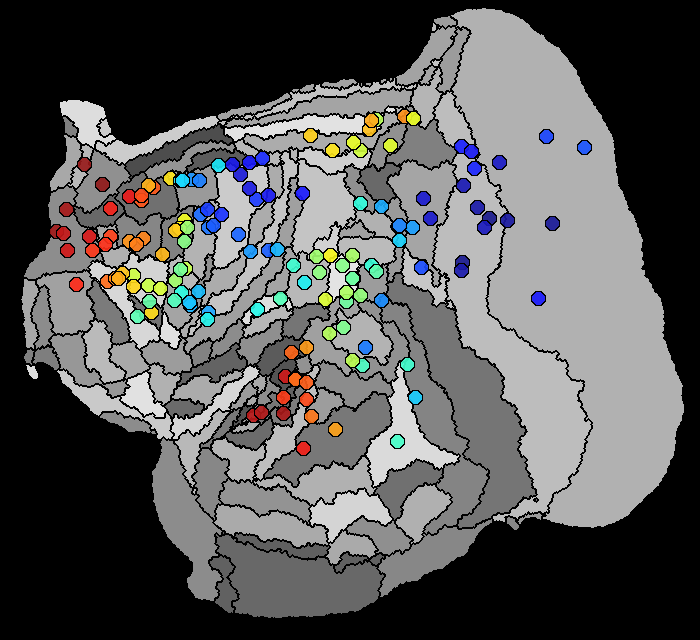

In [22]:
vis_res(1, '../output/results_injections_all_1.png', rev_col = 1)

In [23]:
# Restrict analysis to temporal injections:

df_orig, df, id_flat = load_data(keepTemp = True)
mat = load_mat(df_orig, df, id_flat)
aff = 1 - pairwise_distances(mat, metric='jaccard')
emb = embed.compute_diffusion_map(aff, n_components=3)

/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


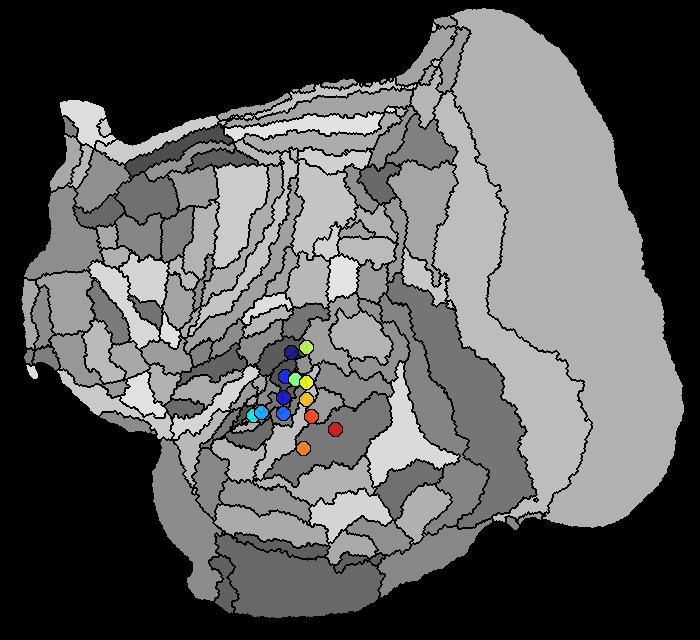

In [25]:
vis_res(0, '../output/results_injections_temp_0.png', rev_col = 0)